# Регрессия для предсказания цен на недвижимость

##### Автор: Виктор Китов ([DeepMachineLearning.ru](https://deepmachinelearning.ru))

##### Лицензия: BSD-3-Clause

В этом ноутбуке мы решаем задачу **регрессии для предсказания цен на недвижимость** на основе характеристик квартир. Целевая переменная — стоимость аренды (total).

## Данные

- **Числовые признаки:** area (площадь), rooms (комнаты), bathroom (ванные), parking_spaces (парковочные места), floor (этаж), hoa (плата за обслуживание)
- **Категориальные признаки:** city (город), animal (животные разрешены), furniture (меблировка)

## План

1. Загрузим и предобработаем данные: удалим выбросы, обработаем пропуски
2. Подготовим признаки: масштабирование числовых признаков через RobustScaler, кодирование категориальных через OneHotEncoder
3. Подберём наилучшие гиперпараметры для моделей: kNN, Ridge Regression, Random Forest, Gradient Boosting
4. Сравним модели по RMSE на кросс-валидации и тестовой выборке
5. Проанализируем лучшую модель: важность признаков, парциальные зависимости

In [1]:
import numpy as np
import pandas as pd
import openml
import warnings
from collections import OrderedDict
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Отключение предупреждений
warnings.filterwarnings("ignore")

In [3]:
# Глобальные переменные
FOLDS = 5
RANDOM_STATE = 42

## Загрузка и предобработка данных

In [4]:
# Загрузка данных
dataset = openml.datasets.get_dataset(
    dataset_id=44990,
    download_data=True,
    download_qualities=True,
    download_features_meta_data=True
)

# Извлекаем данные
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# Переименование целевой переменной
y.name = "target"

# Объединяем в один DataFrame
df = X.copy()
df["target"] = y

# Определяем столбцы
NUM_COLS = ['area', 'rooms', 'bathroom', 'parking_spaces', 'floor', 'hoa']
CAT_COLS = ['city', 'animal', 'furniture']

# Фильтруем выбросы (как указано в задании)
df = df[df['target'] < 30000].copy()

# Проверяем размер данных после фильтрации
print(f"Размер данных после фильтрации: {df.shape}")
print(f"Количество признаков: {len(NUM_COLS) + len(CAT_COLS)}")
print(f"Целевая переменная: {dataset.default_target_attribute}")

Размер данных после фильтрации: (10679, 10)
Количество признаков: 9
Целевая переменная: total


In [5]:
# Проверка пропусков
print("Проверка пропусков в данных:")
print("-" * 40)
missing_values = df.isnull().sum()
for col, missing in missing_values.items():
    if missing > 0:
        print(f"{col}: {missing} пропусков ({missing/len(df)*100:.2f}%)")

if missing_values.sum() == 0:
    print("Пропуски отсутствуют.")

Проверка пропусков в данных:
----------------------------------------
Пропуски отсутствуют.


In [6]:
# Базовая статистика
print("Статистика числовых признаков:")
print("-" * 40)
print(df[NUM_COLS + ['target']].describe().round(2))

print("\nСтатистика категориальных признаков:")
print("-" * 40)
for col in CAT_COLS:
    print(f"\n{col}:")
    print(df[col].value_counts().head())

Статистика числовых признаков:
----------------------------------------
           area     rooms  bathroom  parking_spaces       hoa    target
count  10679.00  10679.00  10679.00        10679.00  10679.00  10679.00
mean     149.01      2.51      2.23            1.61    913.97   5183.24
std      537.23      1.17      1.41            1.59   1117.14   4430.25
min       11.00      1.00      1.00            0.00      0.00    499.00
25%       56.00      2.00      1.00            0.00    170.00   2060.00
50%       90.00      2.00      2.00            1.00    560.00   3575.00
75%      182.00      3.00      3.00            2.00   1231.50   6750.00
max    46335.00     13.00     10.00           12.00  14130.00  28790.00

Статистика категориальных признаков:
----------------------------------------

city:
city
Sao Paulo         5879
Rio de Janeiro    1499
Belo Horizonte    1256
Porto Alegre      1192
Campinas           853
Name: count, dtype: int64

animal:
animal
accept        8307
not accept   

In [7]:
# Разделение на обучающую и тестовую выборки
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (8543, 9)
Размер тестовой выборки: (2136, 9)


## Подготовка признаков

## Функции для оценки моделей

In [8]:
def evaluate_model(name, model, preprocessor, params):
    """
    Оценивает модель с подбором гиперпараметров через GridSearchCV
    """
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Поиск по сетке на обучающей выборке
    # Используем отрицательный RMSE (greater_is_better=False для MSE)
    grid = GridSearchCV(
        pipe,
        params,
        cv=FOLDS,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_train, y_train)
    
    # Печать результатов
    best_rmse = -grid.best_score_  # Конвертируем обратно в RMSE
    print(
        f"{name:<25} | "
        f"Best CV RMSE: {best_rmse:<8.2f} | "
        f"Best params: {grid.best_params_}"
    )
    
    return grid.best_estimator_, best_rmse

In [9]:
def evaluate_on_test(models_dict, X_test, y_test):
    """
    Оценивает обученные модели на тестовой выборке
    """
    print("=" * 60)
    print(f"{'Модель':<25} | {'Test RMSE':<12} | {'Test R²':<8} | {'Test MAE':<10}")
    print("-" * 60)

    results = {}
    
    for name, model in models_dict.items():
        # Предсказания
        y_pred = model.predict(X_test)
        
        # Метрики
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        print(f"{name:<25} | {rmse:<11.2f} | {r2:<7.3f} | {mae:<9.2f}")
        
        results[name] = {
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'predictions': y_pred
        }
    
    print("=" * 60)
    return results

# OneHotEncoder-кодирование для категориальных признаков

In [10]:
# Препроцессор: RobustScaler для чисел и OneHotEncoder для категорий
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), NUM_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CAT_COLS)
    ]
)

## Подбор гиперпараметров и обучение моделей

In [11]:
# Словарь для хранения лучших моделей
best_models = OrderedDict()
cv_scores = {}

print('Лучшие конфигурации моделей по кросс-валидации на train:')
print('-' * 80)

# 1. Метод ближайших соседей (kNN)
best_model, score = evaluate_model(
    "kNN", 
    KNeighborsRegressor(), 
    preprocessor,
    {'model__n_neighbors': [3, 5, 7, 9, 11, 15, 21, 31, 51]}
)
best_models["kNN"] = best_model
cv_scores["kNN"] = score

# 2. Ridge Regression
best_model, score = evaluate_model(
    "Ridge Regression", 
    Ridge(random_state=RANDOM_STATE), 
    preprocessor,
    {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
)
best_models["Ridge"] = best_model
cv_scores["Ridge"] = score

# 3. Random Forest
best_model, score = evaluate_model(
    "Random Forest", 
    RandomForestRegressor(
        n_estimators=100, 
        min_samples_leaf=5, 
        random_state=RANDOM_STATE,
        n_jobs=-1
    ), 
    preprocessor,
    {'model__max_features': [0.1, 0.3, 0.5, 0.7, 0.9, 'sqrt', 'log2']}
)
best_models["RandomForest"] = best_model
cv_scores["RandomForest"] = score

# 4. Gradient Boosting
best_model, score = evaluate_model(
    "Gradient Boosting", 
    GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.1,
        subsample=0.8,
        random_state=RANDOM_STATE,
        validation_fraction=0.1,
        n_iter_no_change=10
    ), 
    preprocessor,
    {
        'model__criterion': ['friedman_mse', 'squared_error'],
        'model__max_depth': [3, 4, 5, 6, 7]
    }
)
best_models["GradientBoosting"] = best_model
cv_scores["GradientBoosting"] = score

Лучшие конфигурации моделей по кросс-валидации на train:
--------------------------------------------------------------------------------
kNN                       | Best CV RMSE: 2217.37  | Best params: {'model__n_neighbors': 15}
Ridge Regression          | Best CV RMSE: 2604.38  | Best params: {'model__alpha': 1000}
Random Forest             | Best CV RMSE: 2133.99  | Best params: {'model__max_features': 0.5}
Gradient Boosting         | Best CV RMSE: 2149.29  | Best params: {'model__criterion': 'friedman_mse', 'model__max_depth': 5}


## Оценка моделей на тестовой выборке

In [12]:
# Оценка на тестовой выборке
test_results = evaluate_on_test(best_models, X_test, y_test)

Модель                    | Test RMSE    | Test R²  | Test MAE  
------------------------------------------------------------
kNN                       | 2430.29     | 0.725   | 1489.81  
Ridge                     | 4152.34     | 0.198   | 1727.27  
RandomForest              | 2318.72     | 0.750   | 1418.06  
GradientBoosting          | 2348.47     | 0.744   | 1450.91  


# MeanValue-кодирование для категориальных признаков

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanValueEncoder(BaseEstimator, TransformerMixin):
    """
    Mean Value Encoder без CV.
    Преобразует категориальные колонки в среднее целевой переменной по каждой категории.
    """
    def __init__(self, cols=None):
        self.cols = cols
        self.global_mean_ = None
        self.encoders_ = {}

    def fit(self, X, y):
        X = X.copy()
        y = y.copy()

        self.global_mean_ = float(y.mean())
        self.encoders_ = {}

        for col in self.cols:
            means = y.groupby(X[col]).mean()
            self.encoders_[col] = means.to_dict()

        return self

    def transform(self, X):
        X = X.copy()

        for col in self.cols:
            X[col] = (
                X[col]
                .map(self.encoders_[col])
                .astype(float)                 
                .fillna(self.global_mean_)
            )

        return X[self.cols].to_numpy()  

    def get_feature_names_out(self, input_features=None):
        """Возвращает имена признаков после преобразования."""
        # Если переданы имена входных признаков, используем их
        if input_features is not None:
            # Возвращаем только те колонки, которые были закодированы
            return np.array([col for col in input_features if col in self.cols])
        # Иначе возвращаем просто имена колонок
        return np.array(self.cols)        

In [22]:
# Препроцессор: RobustScaler для чисел и OneHotEncoder для категорий
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), NUM_COLS),
        ('cat', MeanValueEncoder(cols=CAT_COLS), CAT_COLS)
    ]
)

## Подбор гиперпараметров и обучение моделей

In [23]:
# Словарь для хранения лучших моделей
best_models = OrderedDict()
cv_scores = {}

print('Лучшие конфигурации моделей по кросс-валидации на train:')
print('-' * 80)

# 1. Метод ближайших соседей (kNN)
best_model, score = evaluate_model(
    "kNN", 
    KNeighborsRegressor(), 
    preprocessor,
    {'model__n_neighbors': [3, 5, 7, 9, 11, 15, 21, 31, 51]}
)
best_models["kNN"] = best_model
cv_scores["kNN"] = score

# 2. Ridge Regression
best_model, score = evaluate_model(
    "Ridge Regression", 
    Ridge(random_state=RANDOM_STATE), 
    preprocessor,
    {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
)
best_models["Ridge"] = best_model
cv_scores["Ridge"] = score

# 3. Random Forest
best_model, score = evaluate_model(
    "Random Forest", 
    RandomForestRegressor(
        n_estimators=100, 
        min_samples_leaf=5, 
        random_state=RANDOM_STATE,
        n_jobs=-1
    ), 
    preprocessor,
    {'model__max_features': [0.1, 0.3, 0.5, 0.7, 0.9, 'sqrt', 'log2']}
)
best_models["RandomForest"] = best_model
cv_scores["RandomForest"] = score

# 4. Gradient Boosting
best_model, score = evaluate_model(
    "Gradient Boosting", 
    GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.1,
        subsample=0.8,
        random_state=RANDOM_STATE,
        validation_fraction=0.1,
        n_iter_no_change=10
    ), 
    preprocessor,
    {
        'model__criterion': ['friedman_mse', 'squared_error'],
        'model__max_depth': [3, 4, 5, 6, 7]
    }
)
best_models["GradientBoosting"] = best_model
cv_scores["GradientBoosting"] = score

Лучшие конфигурации моделей по кросс-валидации на train:
--------------------------------------------------------------------------------
kNN                       | Best CV RMSE: 2269.01  | Best params: {'model__n_neighbors': 11}
Ridge Regression          | Best CV RMSE: 2602.03  | Best params: {'model__alpha': 1000}
Random Forest             | Best CV RMSE: 2132.58  | Best params: {'model__max_features': 0.5}
Gradient Boosting         | Best CV RMSE: 2142.94  | Best params: {'model__criterion': 'friedman_mse', 'model__max_depth': 5}


## Оценка моделей на тестовой выборке

In [24]:
# Оценка на тестовой выборке
test_results = evaluate_on_test(best_models, X_test, y_test)

Модель                    | Test RMSE    | Test R²  | Test MAE  
------------------------------------------------------------
kNN                       | 2503.80     | 0.709   | 1520.07  
Ridge                     | 4160.45     | 0.195   | 1739.44  
RandomForest              | 2317.71     | 0.750   | 1418.45  
GradientBoosting          | 2349.10     | 0.743   | 1442.27  


## Сравнение моделей

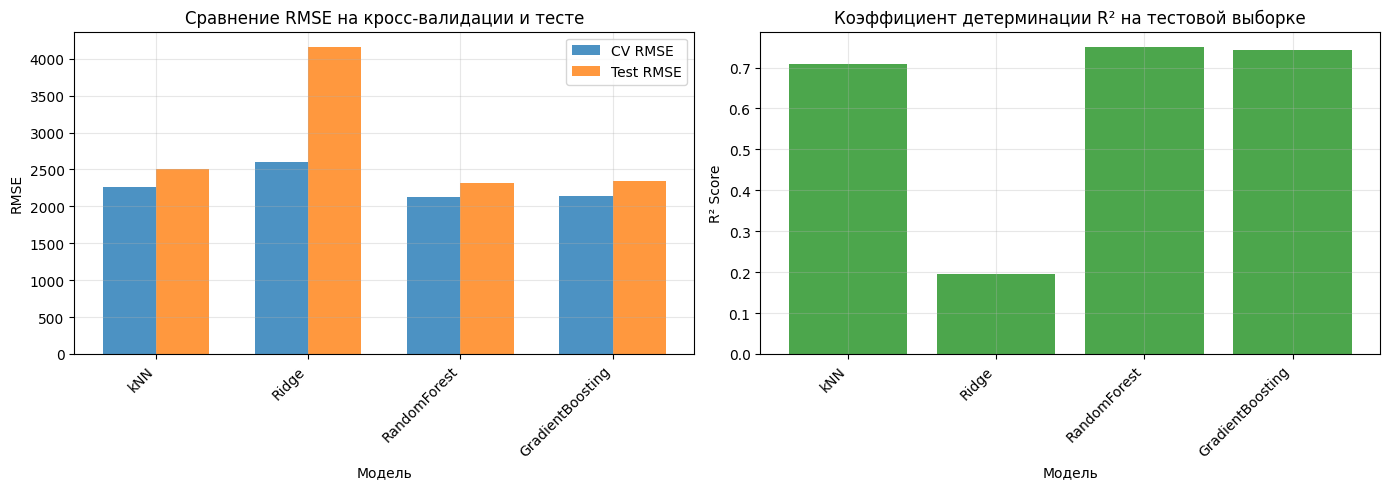

In [25]:
# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Сравнение RMSE
model_names = list(test_results.keys())
test_rmse = [test_results[name]['rmse'] for name in model_names]
cv_rmse = [cv_scores[name] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0].bar(x - width/2, cv_rmse, width, label='CV RMSE', alpha=0.8)
axes[0].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Сравнение RMSE на кросс-валидации и тесте')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Сравнение R²
test_r2 = [test_results[name]['r2'] for name in model_names]

axes[1].bar(model_names, test_r2, alpha=0.7, color='green')
axes[1].set_xlabel('Модель')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Коэффициент детерминации R² на тестовой выборке')
axes[1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Анализ лучшей модели

In [26]:
# Выбираем лучшую модель по тестовому RMSE
best_model_name = min(test_results, key=lambda x: test_results[x]['rmse'])
best_model = best_models[best_model_name]

print(f"Лучшая модель: {best_model_name}")
print(f"Test RMSE: {test_results[best_model_name]['rmse']:.2f}")
print(f"Test R²: {test_results[best_model_name]['r2']:.3f}")
print(f"Test MAE: {test_results[best_model_name]['mae']:.2f}")

Лучшая модель: RandomForest
Test RMSE: 2317.71
Test R²: 0.750
Test MAE: 1418.45


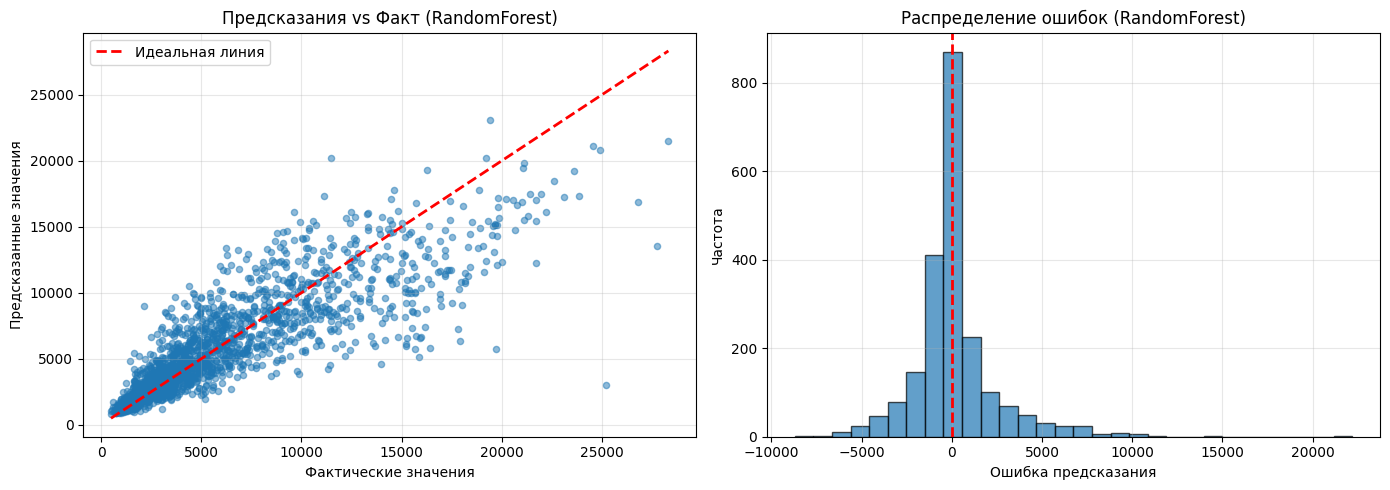

Статистика ошибок предсказаний:
Средняя ошибка: 140.91
Стандартное отклонение ошибок: 2313.96
Медианная абсолютная ошибка: 720.61


In [27]:
# Визуализация предсказаний лучшей модели
y_pred_best = test_results[best_model_name]['predictions']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Фактические vs Предсказанные значения
axes[0].scatter(y_test, y_pred_best, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Идеальная линия')
axes[0].set_xlabel('Фактические значения')
axes[0].set_ylabel('Предсказанные значения')
axes[0].set_title(f'Предсказания vs Факт ({best_model_name})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Распределение ошибок
errors = y_test - y_pred_best
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Ошибка предсказания')
axes[1].set_ylabel('Частота')
axes[1].set_title(f'Распределение ошибок ({best_model_name})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика ошибок
print("Статистика ошибок предсказаний:")
print(f"Средняя ошибка: {errors.mean():.2f}")
print(f"Стандартное отклонение ошибок: {errors.std():.2f}")
print(f"Медианная абсолютная ошибка: {np.median(np.abs(errors)):.2f}")

## Важность признаков

In [28]:
# Получаем имена признаков после препроцессинга
preprocessor = best_model.named_steps['preprocessor']

# Числовые признаки
num_features = NUM_COLS

# Категориальные признаки после OHE
cat_transformer = preprocessor.named_transformers_['cat']
ohe_features = cat_transformer.get_feature_names_out(CAT_COLS)

# Полный список признаков
feature_names = np.concatenate([num_features, ohe_features])

print(f"Всего признаков после препроцессинга: {len(feature_names)}")
print(f"Числовых признаков: {len(num_features)}")
print(f"Категориальных признаков после OHE: {len(ohe_features)}")

Всего признаков после препроцессинга: 9
Числовых признаков: 6
Категориальных признаков после OHE: 3


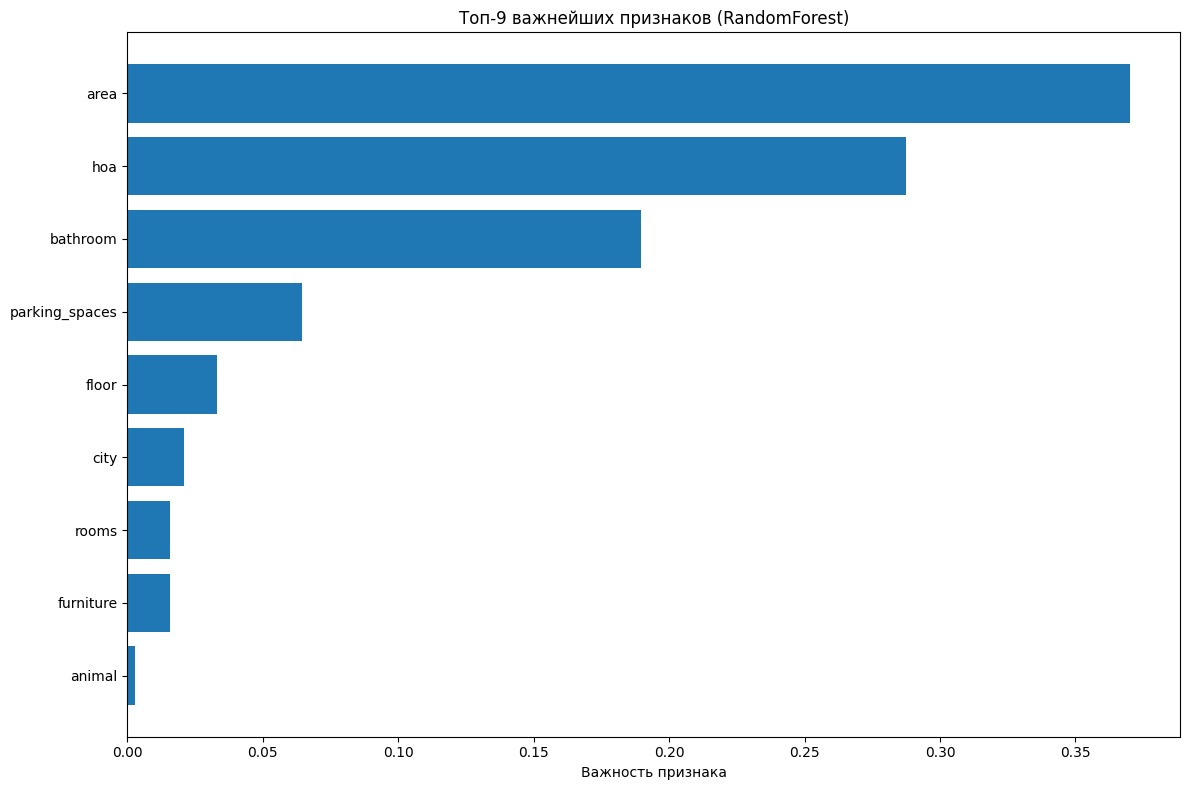

Топ-10 важнейших признаков для RandomForest:
--------------------------------------------------
area: 0.3701
hoa: 0.2876
bathroom: 0.1895
parking_spaces: 0.0646
floor: 0.0331
city: 0.0209
rooms: 0.0158
furniture: 0.0158
animal: 0.0027


In [29]:
# Анализ важности признаков (для Random Forest и Gradient Boosting)
if best_model_name in ["RandomForest", "GradientBoosting"]:
    model = best_model.named_steps['model']
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Создаем DataFrame с важностью признаков
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)
        
        # Визуализация топ-20 признаков
        top_n = min(20, len(importance_df))
        top_features = importance_df.head(top_n)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        y_pos = np.arange(len(top_features))
        ax.barh(y_pos, top_features['importance'])
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_features['feature'])
        ax.invert_yaxis()  # Самые важные сверху
        ax.set_xlabel('Важность признака')
        ax.set_title(f'Топ-{top_n} важнейших признаков ({best_model_name})')
        plt.tight_layout()
        plt.show()
        
        print(f"Топ-10 важнейших признаков для {best_model_name}:")
        print("-" * 50)
        for idx, row in importance_df.head(10).iterrows():
            print(f"{row['feature']}: {row['importance']:.4f}")

# Условные зависимости тагрета от признаков

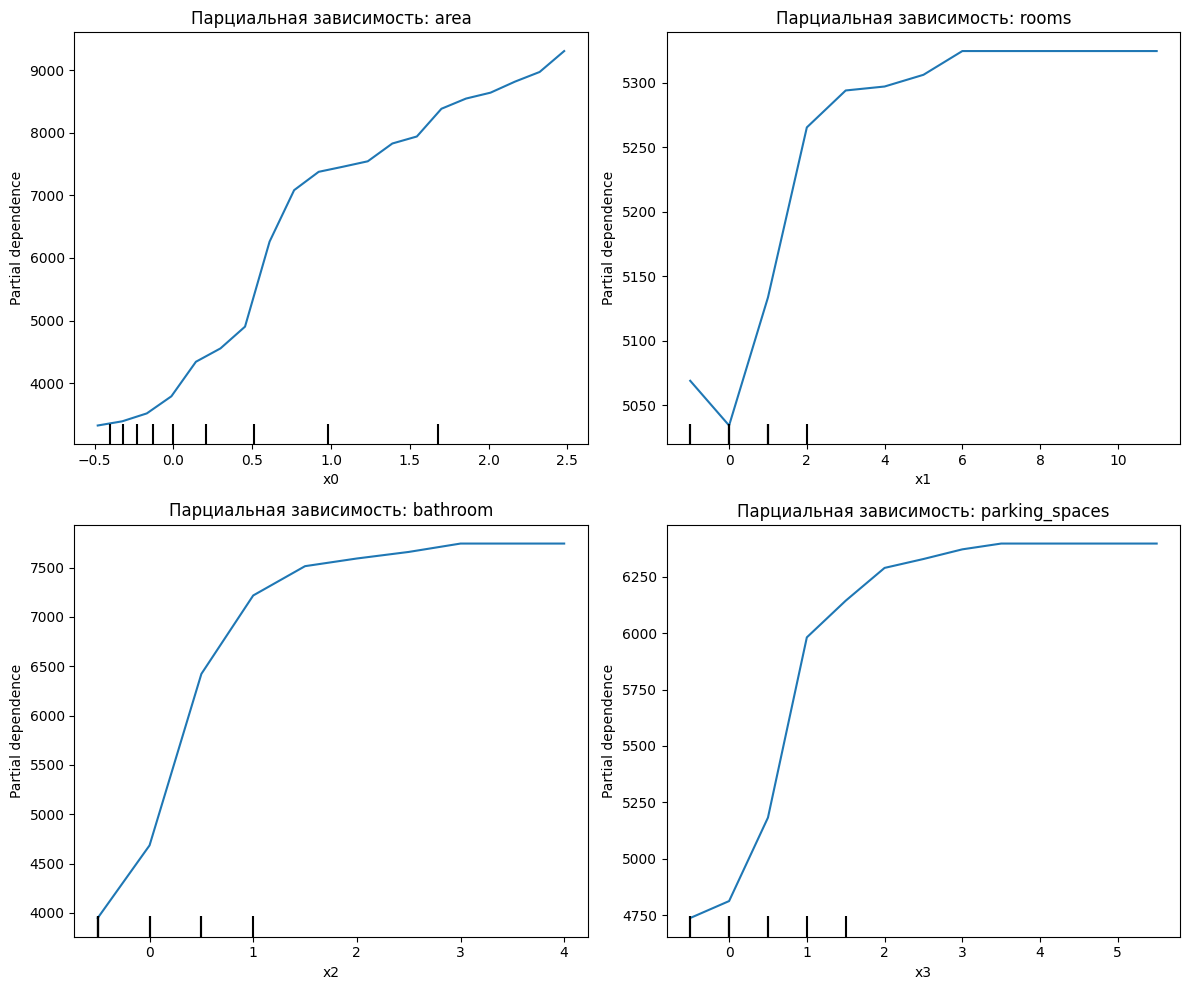

In [30]:
# Парциальные зависимости для важных числовых признаков
if best_model_name in ["RandomForest", "GradientBoosting", "Ridge"]:
    from sklearn.inspection import PartialDependenceDisplay
    
    # Выбираем важные числовые признаки
    important_num_features = ['area', 'rooms', 'bathroom', 'parking_spaces', 'floor', 'hoa']
    
    # Преобразуем данные
    X_train_trans = preprocessor.transform(X_train)
    
    # Получаем индексы признаков
    feature_indices = []
    for feature in important_num_features[:4]:  # Первые 4 признака
        if feature in NUM_COLS:
            feature_indices.append(NUM_COLS.index(feature))
    
    if feature_indices:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.ravel()
        
        for idx, (feature_idx, ax) in enumerate(zip(feature_indices, axes)):
            try:
                display = PartialDependenceDisplay.from_estimator(
                    model,
                    X_train_trans,
                    features=[feature_idx],
                    ax=ax,
                    grid_resolution=20
                )
                feature_name = NUM_COLS[feature_idx]
                ax.set_title(f'Парциальная зависимость: {feature_name}')
                ax.set_xlabel(feature_name)
                ax.set_ylabel('Влияние на предсказание')
                ax.grid(True, alpha=0.3)
            except:
                ax.text(0.5, 0.5, 'Невозможно построить', 
                        ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'Парциальная зависимость: {NUM_COLS[feature_idx]}')
        
        plt.tight_layout()
        plt.show()